---
# IMPORT

In [32]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical
from IPython.display import clear_output

---
# VARIABLES

In [33]:
EPOCHS = 30
batch_size = 64
data_cater = 'data_cater'#path data for trained
model_name = 'Masked_Model_Best.h5'#name path model created
mapping = {0:'masked', 1:'unmasked'}

---
# LOAD DATA


In [34]:
# Show data to chart
def data_visualization(classes, data):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(classes, data)
    ax.set(title="Dataset's distribution for each Emotion class")
    ax.set(xlabel="Masked", ylabel="#Images")
    ax.grid()

# Load data to features and labels
def load_data(data_path):
    subfolders_ck = os.listdir(data_path)
    data = []
    labels_list = []
    num_images_per_class = []

    for category in subfolders_ck:
        img_list = os.listdir(os.path.join(data_path, category))

        print('Loading:', len(img_list), 'images of category', category)
        for img in img_list:
            pixels=cv2.imread(os.path.join(data_path, category, img))
            data.append(pixels)
            labels_list.append(category)
        num_images_per_class.append(len(img_list))

    le = LabelEncoder()
    labels = le.fit_transform(labels_list)
    labels = to_categorical(labels, 2)

    data = np.array(data)

    print("\nTotal number of uploaded data:", data.shape[0])
    print("Data shape:", (data.shape[1], data.shape[2], data.shape[3]))
    data_visualization(subfolders_ck, num_images_per_class)
    return data, labels

Loading: 1647 images of category masked
Loading: 3007 images of category unmasked

Total number of uploaded data: 4654
Data shape: (128, 128, 3)


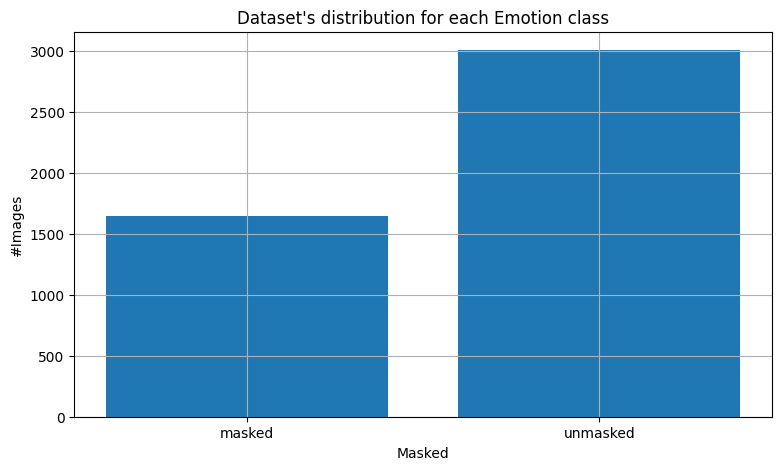

In [35]:
data, labels = load_data(data_cater)

---
# PROCESS

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, shuffle=True, random_state=3)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=3)

In [37]:
trainAug = ImageDataGenerator(rotation_range=15,
                              zoom_range=0.15,
                              brightness_range=(.6, 1.2),
                              shear_range=.15,
                              horizontal_flip=True,
                              fill_mode="nearest")

In [38]:
def build_model():
    #inputs = Input(shape=(48, 48, 3))
    inputs = Input(shape=(128,128,3))
    base_model = EfficientNetB0(include_top=False, weights='imagenet',
                                drop_connect_rate=0.33, input_tensor=inputs)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(.5, name="top_dropout")(x)
    outputs = Dense(2, activation='softmax')(x)
    #outputs = Dense(2, activation='softmax')(x)    
    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

---
# TRAINING

In [39]:
with open(model_name, 'w'):
    pass
model = build_model()

# Set up for training
checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='auto', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)
callbacks = [checkpoint, earlystopping, rlrop]

# Training
print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(trainAug.flow(X_train, y_train, batch_size=batch_size),
                 steps_per_epoch=len(X_train) // batch_size,
                 validation_data=(X_valid, y_valid),
                 epochs=EPOCHS, callbacks=callbacks)

[INFO] training network for 30 epochs...

Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9637
Epoch 1: val_accuracy improved from -inf to 0.99427, saving model to MaskedModelBest4.h5


c:\Users\Klane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 95s 2s/step - loss: 0.0888 - accuracy: 0.9637 - val_loss: 0.0132 - val_accuracy: 0.9943 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9934
Epoch 2: val_accuracy improved from 0.99427 to 0.99713, saving model to MaskedModelBest4.h5
50/50 [==============================] - 74s 1s/step - loss: 0.0173 - accuracy: 0.9934 - val_loss: 0.0048 - val_accuracy: 0.9971 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9928
Epoch 3: val_accuracy improved from 0.99713 to 1.00000, saving model to MaskedModelBest4.h5
50/50 [==============================] - 77s 2s/step - loss: 0.0191 - accuracy: 0.9928 - val_loss: 0.0015 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9956
Epoch 4: val_accuracy did not improve from 1.00000
50/50 [==============================] - 75s 1s/step - lo

---
# PREDICT AND EVALUATE

In [40]:
model = build_model()
model.load_weights(model_name)
clear_output()
model

In [41]:
predict = model.predict(X_test)
predict = np.argmax(np.array(predict), axis=1)
y_test = np.argmax(np.array(y_test), axis=1)

print("Accuracy : " + str(accuracy_score(y_test, predict)))

22/22 [==============================] - 4s 137ms/step
Accuracy : 0.9957081545064378


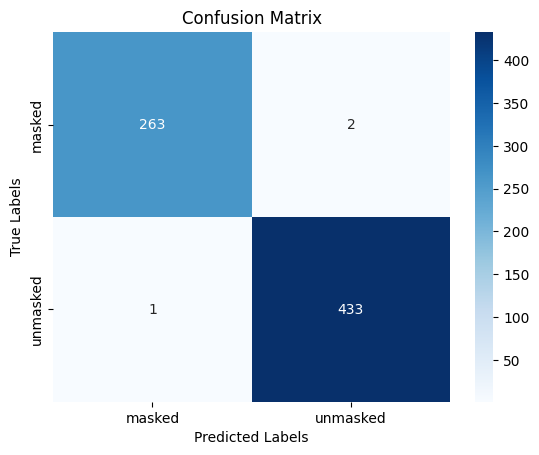

In [42]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predict)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mapping.values(), yticklabels=mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()